<a href="https://colab.research.google.com/github/NikosMav/netlifx_data_analysis/blob/main/netflix_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Τεχνικές Εξόρυξης Δεδομένων (ΥΣ11)**

**1η Προγραμματιστική Άσκηση**

> **Φοιτητές**: Αναστάσιος Μελιδώνης(sdi1700084), Νικόλαος Μαυραπίδης(sdi1700082)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from country_list import countries_for_language
from plotly.subplots import make_subplots
import plotly.express as px

In [ ]:
# Leaving the csv path as it is
netflix_dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Τεδε/Ergasia1/netflix_titles.csv')

# Checking null values
netflix_dataframe.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

# ***Data Cleaning***

As we can see our data frame has some missing data. We can manage that by replacing the missing values. 

First of all, we will fill every non existing Director and Cast cell with the word "Unknown". This will make our data more manageable.

In [ ]:
netflix_dataframe['director'].replace(np.nan,"Unknown",inplace=True)
netflix_dataframe['cast'].replace(np.nan,"Unknown",inplace=True)
netflix_dataframe.isnull().sum()

show_id           0
type              0
title             0
director          0
cast              0
country         507
date_added       10
release_year      0
rating            7
duration          0
listed_in         0
description       0
dtype: int64

Country column is important for our visualization & since it has some null values we can replace them by United States, since United States has the largest nummber of shows.

In [ ]:
netflix_dataframe['country'].value_counts().to_frame().head(1)

,country
United States,2555


In [ ]:
netflix_dataframe['country'].replace(np.nan,"United States",inplace=True)

We follow the same approach for 'date_added'.

In [ ]:
netflix_dataframe['date_added'].value_counts().to_frame().head(1)

,date_added
"January 1, 2020",118


In [ ]:
netflix_dataframe['date_added'].replace(np.nan,"January 1,2020",inplace=True)

Release month is important for visualizing our data, so let's separate the month from the date_added column, create a new column for release months only and concat it to our dataframe.

In [ ]:
netflix_date = netflix_dataframe['date_added'].apply(lambda x: x.lstrip().split(" ")[0]).to_frame()
netflix_date.rename(columns = {'date_added' : 'release_month'}, inplace = True)

In [ ]:
netflix_df_new = pd.concat([netflix_dataframe,netflix_date],axis=1)
netflix_df_new.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,release_month
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,August
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,December
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",December
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",November
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,January


Lets clean the rating column.

In [ ]:
netflix_df_new["rating"].isnull().sum()

7

In [ ]:
netflix_df_new['rating'].value_counts().to_frame().head(1)

,rating
TV-MA,2863


Rating column has only 7 null values let's replace the null values with TV-MA since they make up the most amount of Ratings.

In [ ]:
netflix_df_new["rating"].replace(np.nan,"TV-MA",inplace=True)
netflix_df_new.isnull().sum()

show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added       0
release_year     0
rating           0
duration         0
listed_in        0
description      0
release_month    0
dtype: int64

We eliminated all Null values

Add season_count and duration features since they are important for visualizing our data.

In [ ]:
# Count the seasons and create a new column.
netflix_df_new['season_count'] = netflix_df_new.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "", axis = 1)
netflix_df_new['season_count'] = pd.to_numeric(netflix_df_new['season_count'],errors='coerce')
netflix_df_new = netflix_df_new.replace(np.nan, 0, regex=True)
netflix_df_new['season_count'] = pd.to_numeric(netflix_df_new['season_count'], downcast ='signed')
# Replace duration column with just the number of minutes.
netflix_df_new['duration'] = netflix_df_new.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)
netflix_df_new['duration'] = pd.to_numeric(netflix_df_new['duration'],errors='coerce')
netflix_df_new = netflix_df_new.replace(np.nan, 0, regex=True)
netflix_df_new['duration'] = pd.to_numeric(netflix_df_new['duration'], downcast ='signed')

In [ ]:
netflix_df_new.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,release_month,season_count
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,0,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,August,4
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,December,0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",December,0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",November,0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123,Dramas,A brilliant group of students become card-coun...,January,0
5,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016,TV-MA,0,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...,July,1
6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",June,0
7,s8,Movie,187,Kevin Reynolds,"Samuel L. Jackson, John Heard, Kelly Rowan, Cl...",United States,"November 1, 2019",1997,R,119,Dramas,After one of his high school students attacks ...,November,0
8,s9,Movie,706,Shravan Kumar,"Divya Dutta, Atul Kulkarni, Mohan Agashe, Anup...",India,"April 1, 2019",2019,TV-14,118,"Horror Movies, International Movies","When a doctor goes missing, his psychiatrist w...",April,0
9,s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,"December 15, 2017",2008,TV-MA,143,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...,December,0


So we successfully removed all the Null Values and preprocessed all our Data. Now we can visualize our Data.

# ***Visualization***

Movie      5377
TV Show    2410
Name: type, dtype: int64


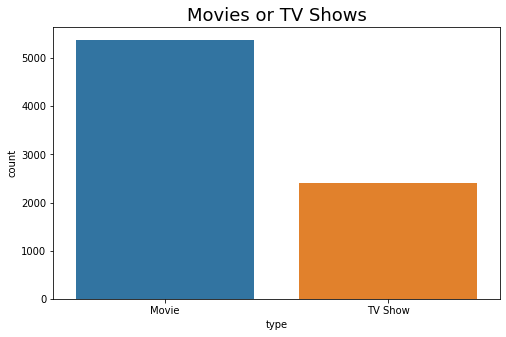

In [ ]:
## 1. Ποιό είδος υπερτερεί, οι ταινίες ή οι σειρές ;
print(netflix_dataframe['type'].value_counts())

plt.figure(figsize=(8,5))
sns.countplot(x='type', data=netflix_dataframe, order=netflix_dataframe.type.value_counts().index[0:2])
plt.title('Movies or TV Shows', size=18);

As can be seen, the number of **Movies** available on Netflix outnumbers **TV** **Shows** by a ration of 2:1.

In [ ]:
## 2. Τα τελευταία χρόνια το netflix επενδύει περισσότερο σε ταινίες ή σε σειρές; 

fig = px.pie(netflix_df_new, values = netflix_df_new['release_year'].value_counts()[:10], names = netflix_df_new['release_year'].value_counts()[:10].index,labels= netflix_df_new['release_year'].value_counts()[:10].index)
fig.update_layout(title="Pie Chart for Distribution of Content based on Year Released")
fig.update_traces(textposition ='inside',textinfo='percent+label')
fig.show()

**2018** was the most productive year for Netflix.

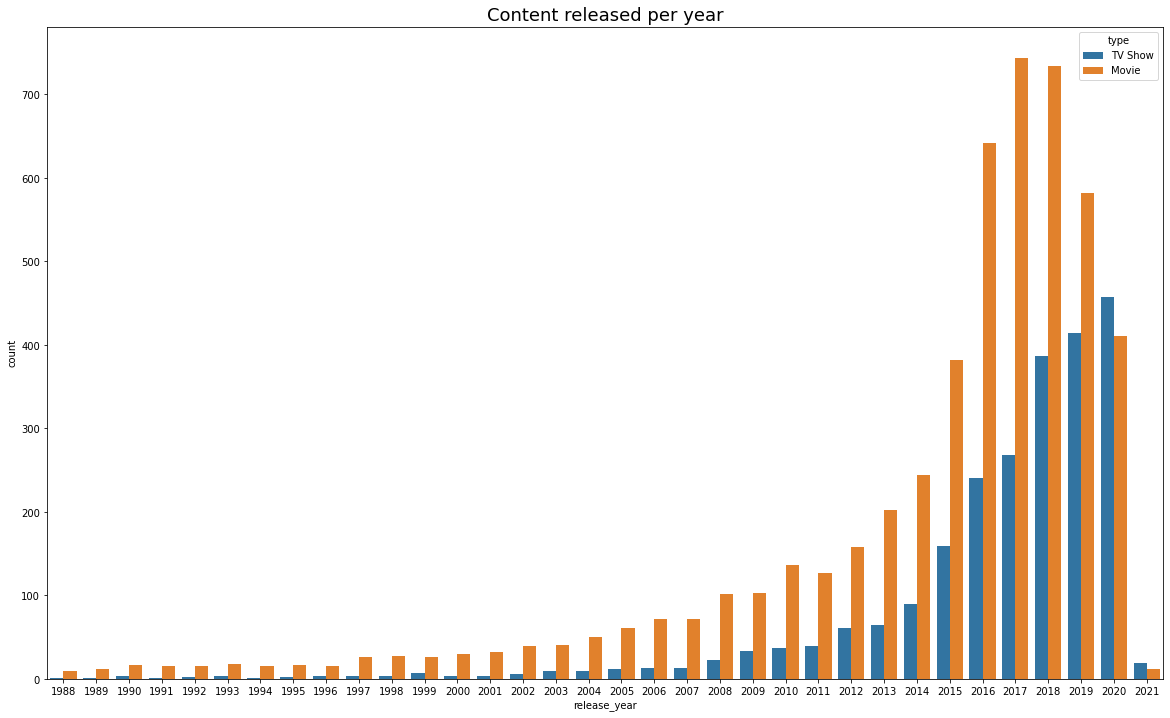

In [ ]:
plt.figure(figsize=(20,12))
sns.countplot(x='release_year',hue='type', data=netflix_dataframe.sort_values(by='release_year')[-1:200:-1]);
plt.title('Content released per year', size=18);

So, **2017** was the year when most of the movies were released. We can also observe that Netflix after the year **2018** is mostly concerned in producing more **TV** **Shows**. This is very clear in the year **2020** in which we see that **TV** **Show** production surmounted the **Movie** production. It is clear that Netflix is lately investing in **producing more TV Shows** than older years. 

Top  1  country/countries with most content: {'United States': 3062}


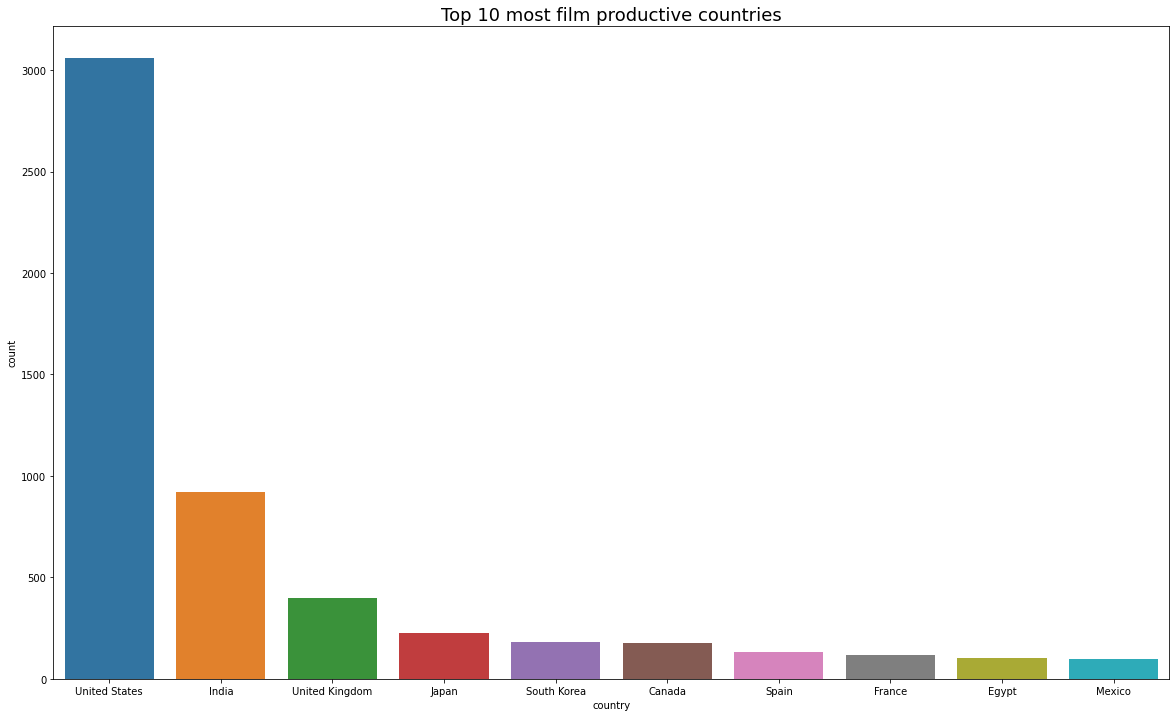

In [ ]:
## 3. Ποιά χώρα έχει το περισσότερο περιεχόμενο; 
def return_counter(data_frame, column_name, limit):
  print('Top ', limit, ' country/countries with most content:', dict(Counter(data_frame[column_name].values).most_common(limit)))

return_counter(netflix_dataframe, 'country', 1)

## Frequency graph by country
plt.figure(figsize=(20,12))
sns.countplot(x='country', data=netflix_dataframe, order=netflix_dataframe.country.value_counts().index[0:10])
plt.title('Top 10 most film productive countries', size=18);

**United** **States** clearly is producing the most content on Netflix.

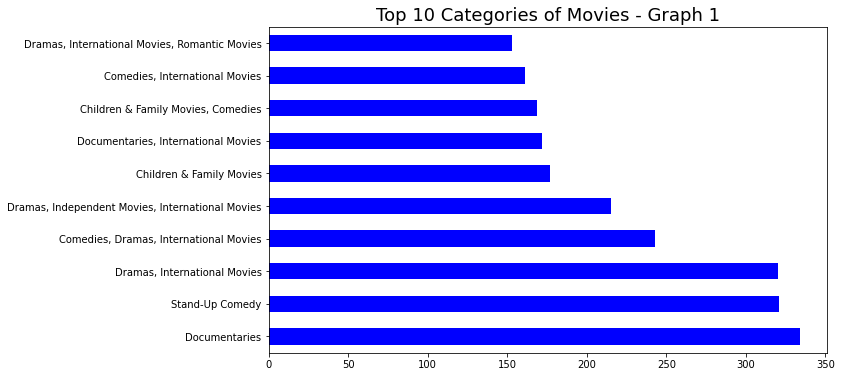

In [ ]:
## 4. Τι είδους περιεχόμενο έχει κάθε χώρα;

# We will look at which Genres are the most popular for Movies...
plt.figure(figsize=(10,6))
netflix_df_new[netflix_df_new["type"]=="Movie"]["listed_in"].value_counts()[:10].plot(kind="barh",color="blue")
plt.title("Top 10 Categories of Movies - Graph 1",size=18);

The data shows that **Documentaries** is the largest category of movies.

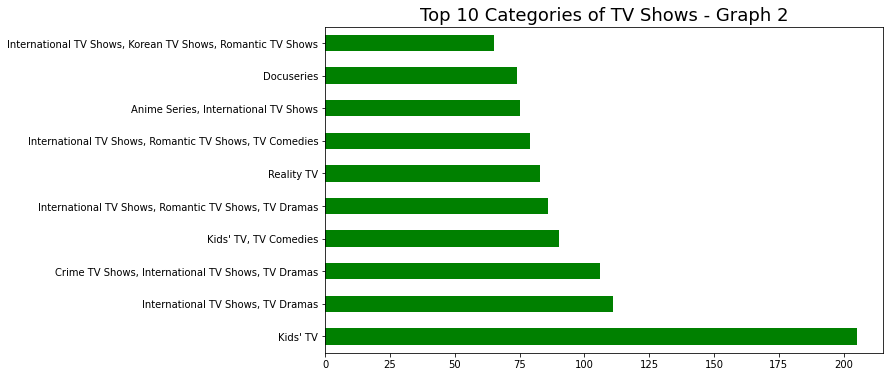

In [ ]:
# and for TV Shows...
plt.figure(figsize=(10,6))
netflix_df_new[netflix_df_new["type"]=="TV Show"]["listed_in"].value_counts()[:10].plot(kind="barh",color="green")
plt.title("Top 10 Categories of TV Shows - Graph 2",size=18);

The data shows that **Kids' Shows** is by far the largest category of shows. The very high number of **Kids TV** shows may also be attributed to the fact that this type of content is cheaper to licence.

In [ ]:
# And then calculate what content does each country provide.
df_new = netflix_df_new.groupby(netflix_df_new["listed_in"])["country"].value_counts()
# Show only the top 20 most produced genres per counrty.
df_new.sort_values(ascending=False).head(20).to_frame()

,,country
listed_in,country,
Documentaries,United States,244
Stand-Up Comedy,United States,234
Children & Family Movies,United States,117
"Dramas, International Movies",India,116
"Comedies, Dramas, International Movies",India,114
Kids' TV,United States,108
"Dramas, Independent Movies, International Movies",India,97
"Children & Family Movies, Comedies",United States,90
Dramas,United States,78


As expected due to **Graph 1** the most produced gerne are **documentaries** by the **United** **States**. Next up are **Stand-Up Comedies and Children & Family Shows** also by the **US**. Then comes **India** with **Drama, International Movies and Comedies, Dramas, International Movies**. As expected again due to **Graph 2** next up is **Kids' TV** from **US**. The list goes on and shows all the content that each country provides. The data is so much that we had to present it in a list and not in a graph form for readability reasons. 

In [ ]:
## 5. Ετοιμάστε γραφήματα που δειχνουν τους ηθοποιούς με τις περισσότερες ταινίες σε κάθε χώρα.

# creating a trace for plotting movies/tv shows
def country_trace(country, flag = "movie"):
  netflix_df_new["from_us"] = netflix_df_new['country'].fillna("").apply(lambda x : 1 if country.lower() in x.lower() else 0)
  small = netflix_df_new[netflix_df_new["from_us"] == 1]
  if flag == "movie":
      small = small[small["duration"] != ""]
  else:
      small = small[small["season_count"] != ""]
  cast = ", ".join(small['cast'].fillna("")).split(", ")

  if cast[0] == '':
    return -1

  tags = Counter(cast).most_common(25)
  tags = [_ for _ in tags if "" != _[0]]

  labels, values = [_[0]+"  " for _ in tags], [_[1] for _ in tags]
  trace = go.Bar(y=labels[::-1], x=values[::-1], orientation="h", name="", marker=dict(color="#a678de"))

  # print(cast)
  return trace


# getting a country list for ease of use
countries = dict(countries_for_language('en'))
traces = []
titles = []

newline = 0

# creating traces for NON empty countries and creating titles for the graphs
for title in countries:
  if country_trace(countries[title], flag="movie") != -1:
    traces.append(country_trace(countries[title], flag="movie"))
    titles.append(countries[title])
    newline+=1
    if(newline !=2):
      titles.append("")
    else:
      newline=0


titles.pop()
# geting 20 countries, change this number to see more or less countries
countries_num = 20

fig = make_subplots(rows=countries_num//2, cols=3, subplot_titles=titles)

# row of plot
j = 1

# creating the plot
for i in range(0,countries_num,2):
  fig.add_trace(traces[i], j, 1)
  fig.add_trace(traces[i+1], j, 3)
  j += 1


fig.update_layout(height=2400, showlegend=False)
fig.show()

We can get the information for the **cast** of the movies of a country by creating a suitable dataframe for each country. Also a dataframe of **Movies** is different from a dataframe of **TV Shows** and this is differentiated in the **country_trace** function

In [ ]:
## 5. Το ίδιο και για τις σειρές.

traces = []
titles = []

# geting 30 countries, change this number to see more or less countries
countries_num = 30
newline = 0
# creating traces for NON empty countries and creating titles for the graphs
for title in countries:
  if country_trace(countries[title], flag="tv_shows") != -1:
    traces.append(country_trace(countries[title], flag="tv_shows"))
    titles.append(countries[title])
    newline+=1
    if(newline !=2):
      titles.append("")
    else:
      newline=0

titles.pop()


fig = make_subplots(rows=countries_num//2, cols=3, subplot_titles=titles)

# row of plot
j = 1

# creating the plot
for i in range(0,countries_num,2):
  fig.add_trace(traces[i], j, 1)
  fig.add_trace(traces[i+1], j, 3)
  j += 1

fig.update_layout(height=2600, showlegend=False)
fig.show()

Doing the same thing for the **TV Shows**

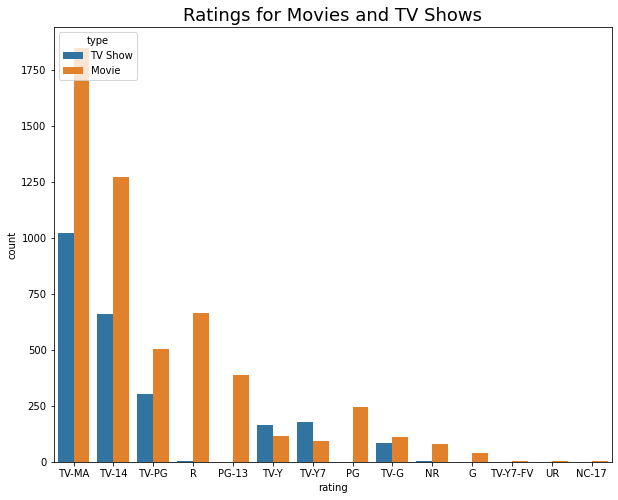

In [ ]:
## 6. Το netflix υποστηρίζει ότι παρέχει πλούσιο περιεχόμενο για όλες τις ηλικίες. Αληθεύει αυτό;

plt.figure(figsize = (10,8))
# First plot every rating for movies and tv shows
sns.countplot(x="rating",data= netflix_df_new, hue= "type", order = netflix_df_new['rating'].value_counts().index[0:15])
plt.title('Ratings for Movies and TV Shows', size=18);

As shown above the Movies & TV Shows with a rating of **TV-MA** are in the clear majority. Next up is **TV-14**, **TV-PG** and **R**, which consists mostly of Movies.

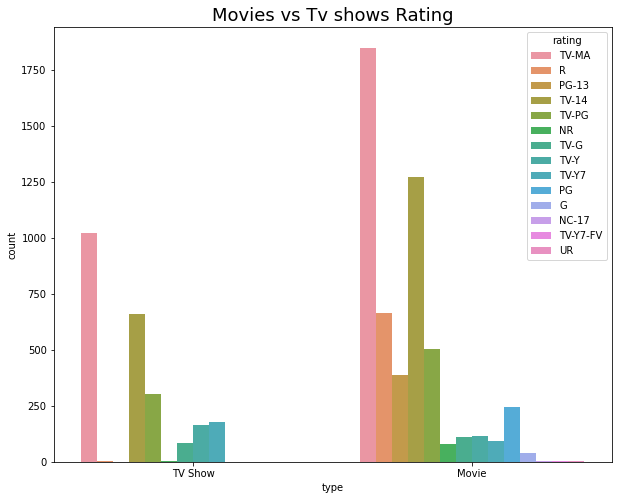

In [ ]:
plt.figure(figsize=(10,8))
# Then differentiate the ratings for Movies and TV Shows
sns.countplot(x='type',hue='rating',data=netflix_df_new)
plt.title("Movies vs Tv shows Rating", size=18);

Differentiating the ratings between Movies and TV shows shows a fairly 2:1 ratio **across the categories**.

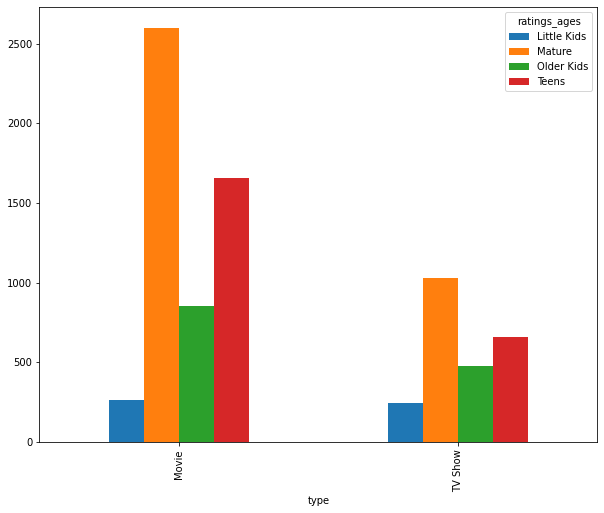

In [ ]:
# Creating a dictionary for ratings.
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Mature',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Mature',
    'TV-Y': 'Little Kids',
    'NR': 'Mature',
    'PG-13': 'Teens',
    'TV-G': 'Little Kids',
    'PG': 'Older Kids',
    'G': 'Little Kids',
    'UR': 'Mature',
    'NC-17': 'Mature'
}

# Add a new column 'rating_ages' to our dataframe based on the above dictionary
netflix_df_new["ratings_ages"] = netflix_df_new["rating"].replace(ratings_ages)

pd.crosstab(netflix_df_new["type"],netflix_df_new["ratings_ages"]).plot(kind="bar", figsize=(10,8))

It is clear that Netflix produces more **mature content** both in **Movies** and in **TV** **Shows**. Next up is content that is dedicated for **Teenagers**. **Older** **Kids** and **Little** **Kids** come in last place. This graph shows that Netflix does **not** provide a wide **variety of movies** for all ages and it tends to release more mature content. When it comes to the **TV** **Shows**, however, Netflix provides **content available for all ages** and tries to keep a balance between the different age groups.

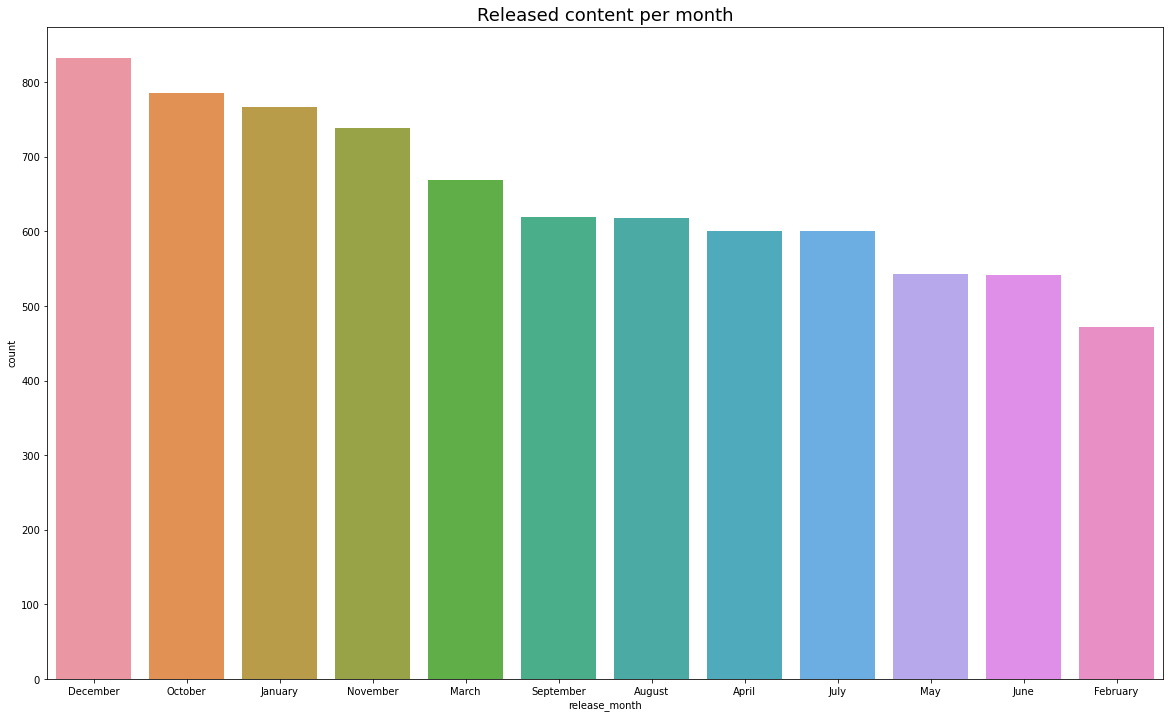

In [ ]:
## 7. Κάντε ένα γράφημα με το περιεχόμενο που προστίθεται ανά μήνα.

plt.figure(figsize=(20,12))
sns.countplot(x='release_month', data=netflix_df_new, order=netflix_df_new['release_month'].value_counts().index[0:12])
plt.title('Released content per month', size=18);

As we can observe the most content is being released during the month of **December**. That could be due to the fact that during the month of December is the holiday season.

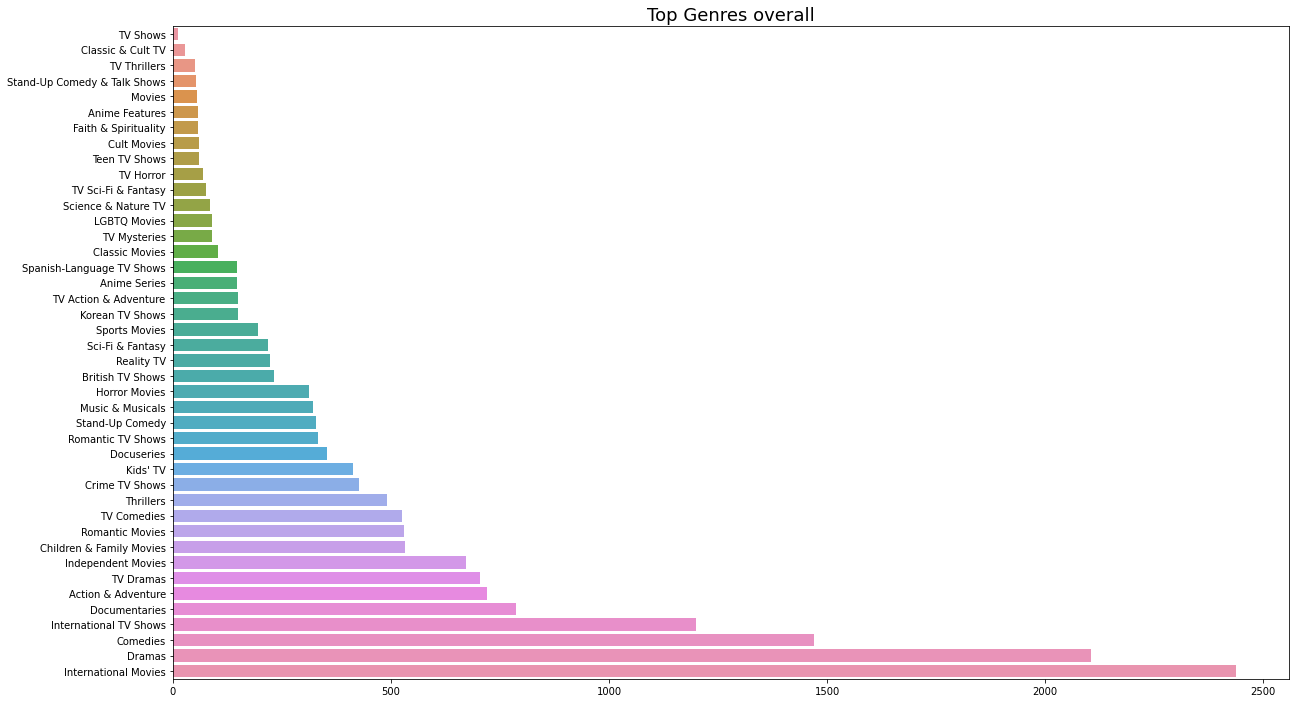

In [ ]:
## 8. Ετοιμάστε ένα γράφημα που παρουσιάζει συγκεντρωτικά τα είδη του περιεχομένου.

categories = ", ".join(netflix_df_new['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]

plt.figure(figsize=(20,12))
sns.barplot(y=labels, x=values)
plt.title('Top Genres overall', size=18);

It is clear that **International Movies** is the most common genre used in Netflix content. This actually makes sense given the fact that Netflix has many countries producing content and cooperating with each other.

In [ ]:
## 9. Μελετηστε τους σκηνοθέτες ανά χώρα και παρουσιάστε σχετικά γραφήματα. 

# showing the top directors of a country
def directors_most_content(country):
  small = netflix_df_new[netflix_df_new["country"] == country]
  col = "director"
  categories = ", ".join(small[col].fillna("")).split(", ")
  counter_list = Counter(categories).most_common(12)
  counter_list = [_ for _ in counter_list if _[0] != ""]
  # if there are none then just return
  if(len(counter_list) == 0):
    return -1
  labels = [_[0] for _ in counter_list][::-1]
  values = [_[1] for _ in counter_list][::-1]
  trace1 = go.Bar(y=labels, x=values, orientation="h", name="TV Shows", marker=dict(color="orange"))
  data = [trace1]
  layout = go.Layout(title="Movie Directors from " + country + " with most content", legend=dict(x=0.1, y=1.1, orientation="h"))

  fig = go.Figure(data, layout=layout)
  fig.show()

  # everything's good
  return 0

# iterating through the countries
counter = 0
for index in countries:
  # checking the directors of this country, if the function returned -1 just go to the next country
  if directors_most_content(countries[index]) == -1:
    continue
  counter+=1
  # CHANGE THIS NUMBER IF YOU WANT TO SEE MORE OR LESS COUNTRIES
  if counter == 20:
    break

In order to study the **directors** of each country, we need to create a new dataframe for each country. Having a dataframe with each movie of a country we can easily get the information for the **directors** of that country.

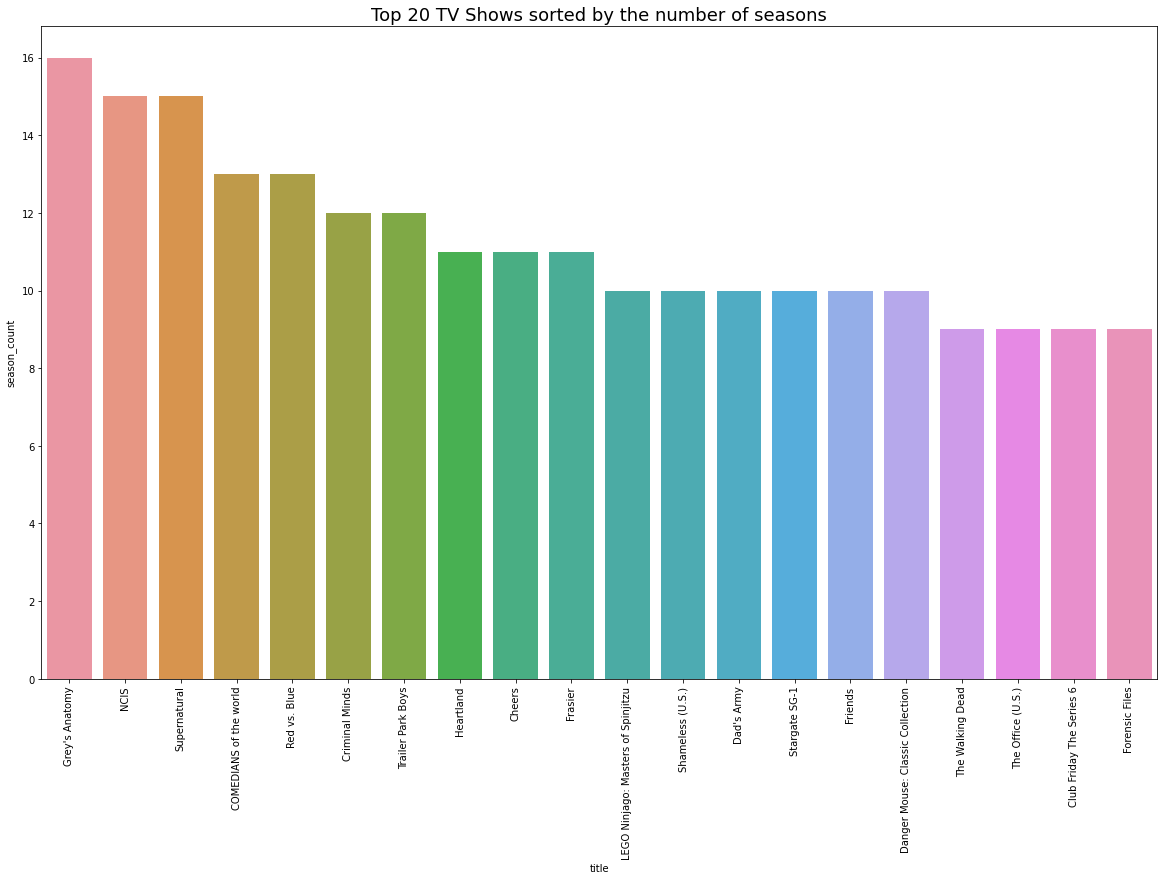

In [ ]:
## 10. Μελετήστε τις σειρές και παρουσιάστε ένα γράφημα που τις δείχνει ανάλογα με τον αριθμό των seasons.

# Create a new dataframe for TV Shows and their seasons.
season_df = netflix_df_new[netflix_df_new["type"]=="TV Show"]
season_df = season_df[['type', 'title', 'season_count']]
sorted = season_df.sort_values(by='season_count', ascending=False).reset_index(drop=True)

plt.figure(figsize = (20,12))
# Lets print the top 20 TV Shows by number of seasons.
top = 20
sns.barplot(x="title", y="season_count", data=sorted[0:top])
plt.xticks(rotation=90);
plt.title('Top 20 TV Shows sorted by the number of seasons', size=18);

We created previously a column called "**season_count**". By creating a new dataframe using the needed columns ("season_count", "title", "type"), we can easily find the **TV Shows with the most seasons**!

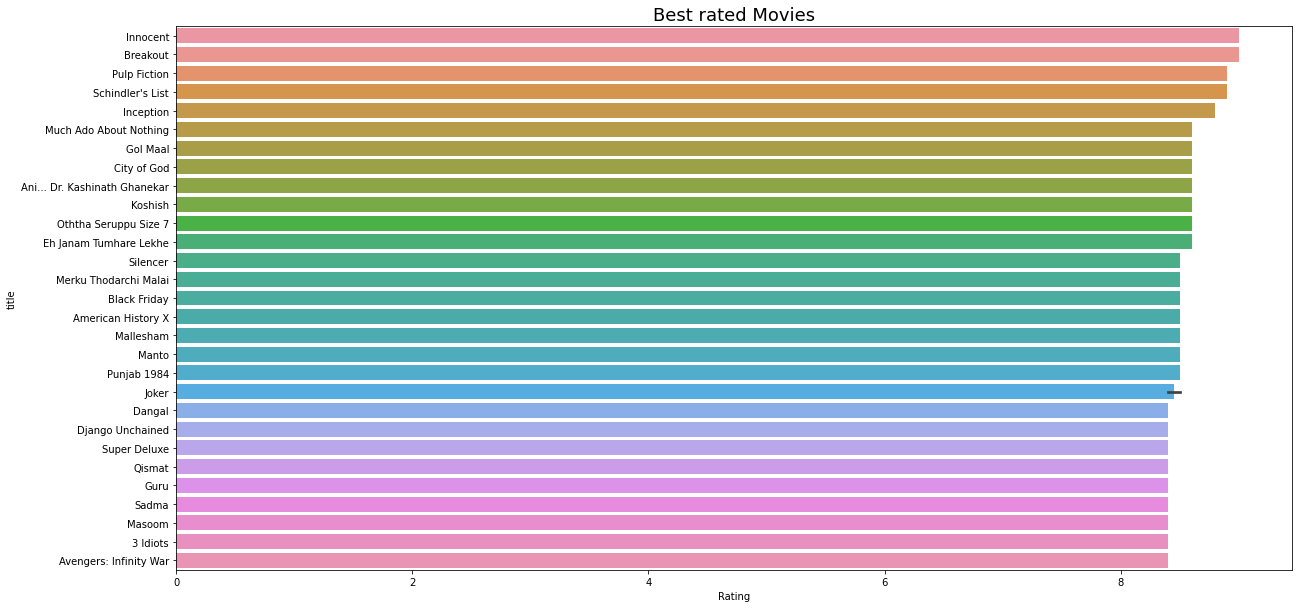

In [ ]:
## 11. Ποιές είναι οι ταινίες με την πιο υψηλή βαθμολογία;

# CHANGE THIS IF YOU WANT TO SEE MORE OR LESS TOP RATED MOVIES
top_rated_movies = 30

# reading IMDB Ratings 
imdb_ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Τεδε/Ergasia1/IMDb ratings.csv',usecols=['weighted_average_vote'],low_memory=False)
# reading IMDB Titles 
imdb_titles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Τεδε/Ergasia1/IMDb movies.csv', usecols=['title','year','genre'],low_memory=False)

# creating a new dataframe
ratings = pd.DataFrame({'Title':imdb_titles.title,
                    'Release Year':imdb_titles.year,
                    'Rating': imdb_ratings.weighted_average_vote,
                    'Genre':imdb_titles.genre})
ratings.drop_duplicates(subset=['Title','Release Year','Rating'], inplace=True)

ratings.dropna()

# merging dataframes
joint_data=ratings.merge(netflix_df_new,left_on='Title',right_on='title',how='inner')
joint_data=joint_data.sort_values(by='Rating', ascending=False)

# Getting the N top rated movies
top_rated=joint_data[0:top_rated_movies]

# plotting
plt.figure(figsize=(20,10))
sns.barplot(y='title', x='Rating', data=top_rated)
plt.title('Best rated Movies', size=18);

We need to find the highest rated movies. In order to do that we need to use 2 new files, specifically **IMDb ratings.csv** & **IMDb movies.csv**.

By creating a new dataframe using a combination of columns by both files gives us the ability to mine the information that we want. Specificaly using **weighted_average_vote** & **title** columns

# ***Recommendation System***

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
import numpy as np
import heapq
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import jaccard_score

In [ ]:
# Create the new dataframe for this part.
recommendation_df = netflix_df_new[['show_id', 'title', 'description']]

# Concat titles and descriptions.
recommendation_df['text'] = recommendation_df['title'] + ' ' + recommendation_df['description']
recommendation_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,show_id,title,description,text
0,s1,3%,In a future where the elite inhabit an island ...,3% In a future where the elite inhabit an isla...
1,s2,7:19,After a devastating earthquake hits Mexico Cit...,7:19 After a devastating earthquake hits Mexic...
2,s3,23:59,"When an army recruit is found dead, his fellow...","23:59 When an army recruit is found dead, his ..."
3,s4,9,"In a postapocalyptic world, rag-doll robots hi...","9 In a postapocalyptic world, rag-doll robots ..."
4,s5,21,A brilliant group of students become card-coun...,21 A brilliant group of students become card-c...
...,...,...,...,...
7782,s7783,Zozo,When Lebanon's Civil War deprives Zozo of his ...,Zozo When Lebanon's Civil War deprives Zozo of...
7783,s7784,Zubaan,A scrappy but poor boy worms his way into a ty...,Zubaan A scrappy but poor boy worms his way in...
7784,s7785,Zulu Man in Japan,"In this documentary, South African rapper Nast...","Zulu Man in Japan In this documentary, South A..."
7785,s7786,Zumbo's Just Desserts,Dessert wizard Adriano Zumbo looks for the nex...,Zumbo's Just Desserts Dessert wizard Adriano Z...


In [ ]:
# define BOW 
CountVec = CountVectorizer(
                          ngram_range=(1,2), # (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
                          stop_words='english',
                          max_df=0.4,
                          min_df=1,
                          max_features=10000,
                          lowercase=True
                          )
#transform
bow_data = CountVec.fit_transform(recommendation_df['text'])
 
#create dataframe
bow_dataframe=pd.DataFrame(bow_data.toarray(),columns=CountVec.get_feature_names())
bow_dataframe

,000,000 euros,000 prize,000 years,007,009,10,10 000,10 year,10 years,100,100 000,100 days,100 years,101,10th,11,11 year,12,12 year,12 years,12th,13,13 reasons,13 year,13 years,13th,14,14 year,14th,14th century,15,15 year,15 years,16,16 year,16 years,16th,16th century,17,...,young man,young men,young mother,young musicians,young newlywed,young orphan,young police,young son,young university,young woman,young women,younger,younger brother,younger sister,younger woman,youngest,youngsters,youth,youths,youtube,youtube sensation,yu,yuletide,yuppie,zac,zach,zach galifianakis,zack,zany,zealand,zero,zindagi,zion,zodiac,zoe,zombie,zombie apocalypse,zombies,zone,zulu
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7784,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7785,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#define tf-idf
tf_idf_vec = TfidfVectorizer(
                        use_idf=True,
                        ngram_range=(1,2), # (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
                        max_features=10000,
                        max_df=0.4,    # drop words that occur in more than X percent of documents
                        min_df=1,      # only use words that appear at least X times
                        smooth_idf=True, # Prevents divide-by-zero errors
                        lowercase=True, # Convert everything to lower case 
                        stop_words='english'
                        )
#transform
tf_idf_data = tf_idf_vec.fit_transform(recommendation_df['text'])
 
#create dataframe
tf_idf_dataframe=pd.DataFrame(tf_idf_data.toarray(),columns=tf_idf_vec.get_feature_names())
tf_idf_dataframe

,000,000 euros,000 prize,000 years,007,009,10,10 000,10 year,10 years,100,100 000,100 days,100 years,101,10th,11,11 year,12,12 year,12 years,12th,13,13 reasons,13 year,13 years,13th,14,14 year,14th,14th century,15,15 year,15 years,16,16 year,16 years,16th,16th century,17,...,young man,young men,young mother,young musicians,young newlywed,young orphan,young police,young son,young university,young woman,young women,younger,younger brother,younger sister,younger woman,youngest,youngsters,youth,youths,youtube,youtube sensation,yu,yuletide,yuppie,zac,zach,zach galifianakis,zack,zany,zealand,zero,zindagi,zion,zodiac,zoe,zombie,zombie apocalypse,zombies,zone,zulu
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7783,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7784,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.309619
7785,0.221366,0.0,0.283566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234024,0.273579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0

Calculating the cosine similarity matrix for all movies.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(tf_idf_dataframe)

There is no pairwise version of the jaccard_similarity_score but there are pairwise versions of **other** **distances**.
SciPy defines Jaccard distance as follows:

*Given two vectors, u and v, the Jaccard distance is the proportion of those elements u[i] and v[i] that disagree where at least one of them is non-zero.*

So it excludes the rows where both columns have $0$ values. jaccard_similarity_score doesn't. **Hamming** distance, on the other hand, is inline with the similarity definition:

*The proportion of those vector elements between two n-vectors u and v which disagree.*

So in order to calculate jaccard_similarity_score faster, we can use $1 - hamming$:

Calculating the Jaccard/Tanimoto similarity matrix for all movies. 

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

jac_sim = 1 - pairwise_distances(bow_dataframe, metric = "hamming")

**Enumeration** and **indexing** of all Movies in the Dataframe.

In [ ]:
indices = pd.Series(recommendation_df.index, index=recommendation_df['title']).drop_duplicates()
indices

title
3%                                            0
7:19                                          1
23:59                                         2
9                                             3
21                                            4
                                           ... 
Zozo                                       7782
Zubaan                                     7783
Zulu Man in Japan                          7784
Zumbo's Just Desserts                      7785
ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS    7786
Length: 7787, dtype: int64

Creation of **two** **dictionaries** for storing for each movie the **top** **100** most similar movies. One dictionary for the **BOW** method and the other for the **cosin** method. This will provide easy access to our programm for future predicitons.

In [ ]:
# Dictionaries for both cosine_similarity matrix and jaccard_similarity matrix.
# For each movie store the top 100 most similar movies
jac_dict = {}
cos_dict = {}

for idx in indices:

  # Get the pairwise similarity scores of all movies with that movie
  score_array_jac = list(enumerate(jac_sim[idx]))
  score_array_cos = list(enumerate(cos_sim[idx]))

  # Sort the movies based on the similarity scores
  score_array_jac.sort(key=lambda x: x[1], reverse=True)
  score_array_cos.sort(key=lambda x: x[1], reverse=True)

  # Get the scores of the 100 most similar movies
  score_array_jac = score_array_jac[1:100+1]
  score_array_cos = score_array_cos[1:100+1]

  # Get the movie indices
  movie_indices_jac = [i[0] for i in score_array_jac]
  movie_indices_cos = [i[0] for i in score_array_cos]

  # Store the top 100 most similar movies
  jac_dict[idx] = recommendation_df['title'].iloc[movie_indices_jac]
  cos_dict[idx] = recommendation_df['title'].iloc[movie_indices_cos]


Recommendation funtion **get_similar_movies1()**

In [ ]:
def get_similar_movies1(title, N, method='boolean'):
  idx = indices[title]

  if(method == 'boolean'):
    movie_array = jac_dict[idx]
    return movie_array.head(N)
  elif(method == 'tf-idf'):
    movie_array = cos_dict[idx]
    return movie_array.head(N)
  else:
    print('wrong method')
    return -1

In [ ]:
get_similar_movies1("Mortel", 10, 'boolean')

6023                 Teresa
1267              Chamatkar
5741              Spartacus
7549      WHAT DID JACK DO?
821          Being Napoleon
891         Bhool Bhulaiyaa
2263                Frasier
2403         Ghost Whispers
4142    Miss Representation
5602                 Signal
Name: title, dtype: object

In [ ]:
get_similar_movies1("Mortel", 10, 'tf-idf')

979                                Blind Detective
608                                 At First Light
2159                             Figures of Speech
3864                              Maharakshak Devi
1267                                     Chamatkar
4314    My Entire High School Sinking Into the Sea
4033                              Men on a Mission
6958                          The Umbrella Academy
5602                                        Signal
6429                                     The Guest
Name: title, dtype: object

We observe that there's no time difference between these two because the most similar movies for each movie have been precalculated, but each method yields different results. As you can see the "tf-idf" method yields more relatable results than the "BoW" method!

Here for the next recommendation function we will split the **recommendation_df** in **text_df** which only has the 'text' column 

In [ ]:
text_df = recommendation_df['text']
text_df

0       3% In a future where the elite inhabit an isla...
1       7:19 After a devastating earthquake hits Mexic...
2       23:59 When an army recruit is found dead, his ...
3       9 In a postapocalyptic world, rag-doll robots ...
4       21 A brilliant group of students become card-c...
                              ...                        
7782    Zozo When Lebanon's Civil War deprives Zozo of...
7783    Zubaan A scrappy but poor boy worms his way in...
7784    Zulu Man in Japan In this documentary, South A...
7785    Zumbo's Just Desserts Dessert wizard Adriano Z...
7786    ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS This d...
Name: text, Length: 7787, dtype: object

Function for calculating the **jaccard** **similarity** between a certain description that the user gives and all other movies and tv shows in our dataframe. We use this **instead** of calculating again the **pairwise** **matrix** which saves us a lot of **time**.

In [ ]:
def compute_jaccard_similarity(index, cv_dataframe=bow_dataframe):
  jaccard_sim = []
  for j in range(len(cv_dataframe.index)):
    jaccard_sim.append(jaccard_score(cv_dataframe.iloc[index], cv_dataframe.iloc[j], average='macro'))
 
  return jaccard_sim

Recommendation function **get_similar_movies2()**

In [ ]:
def get_similar_movies2(text, N, method='boolean', text_df=text_df):

  # Create a new Series with the only item the description the user gave.
  d = {'text': text}
  text = pd.Series(data=d, index=['text'])
  # Concat the newly made df with the old one.
  new_text_df = text_df.append(text, ignore_index=True)
  
  if(method == 'boolean'):
    # Transform
    bow_data = CountVec.fit_transform(new_text_df)
    # Create Dataframe
    bow_dataframe=pd.DataFrame(bow_data.toarray(),columns=CountVec.get_feature_names())
    # Compute Jaccard Similarity for the last index (the description that the user gave)
    jac_sim = compute_jaccard_similarity(-1, bow_dataframe)
    score_array = list(enumerate(jac_sim))
    
  elif(method == 'tf-idf'):
    #transform
    tf_idf_data = tf_idf_vec.fit_transform(new_text_df)
    #create dataframe
    tf_idf_dataframe=pd.DataFrame(tf_idf_data.toarray(),columns=tf_idf_vec.get_feature_names())
    # Get the pairwise similarity scores of all movies with that movie
    cosine_sim = cosine_similarity(tf_idf_dataframe)
    score_array = list(enumerate(cosine_sim[-1]))
    
  else:
    print('wrong method')
    return -1

  # Sort the movies based on the similarity scores
  score_array.sort(key=lambda x: x[1], reverse=True)
  # Get the scores of the 10 most similar movies
  score_array = score_array[1:N+1]
  # Get the movie indices
  movie_indices = [i[0] for i in score_array]

  # Return the top N most similar movies
  return recommendation_df['title'].iloc[movie_indices]  

**Results** for **get_similar_movies2()**

In [ ]:
get_similar_movies2("war between vietnam and usa", 10, 'boolean')

4879                       Platoon
1569                   Da 5 Bloods
3462    Kulipari: An Army of Frogs
3524                       Lakshya
6651                      The Maus
1736                 Dharmakshetra
3646                       Lincoln
3761                   Love Is War
264                         Aadu 2
1580                     Daemonium
Name: title, dtype: object

In [ ]:
get_similar_movies2("war between vietnam and usa", 10, 'tf-idf')

6980    The Vietnam War: A Film by Ken Burns and Lynn ...
4879                                              Platoon
611                                             Athlete A
1569                                          Da 5 Bloods
2589                                       Hamburger Hill
6848                                        The Sapphires
7175              Trailer Park Boys: Out of the Park: USA
4359                                     My Stupid Boss 2
7043                                              Thi Mai
7479                                          War Machine
Name: title, dtype: object

In [ ]:
get_similar_movies2("Mickey Mouse", 10, 'boolean')

2380    Geronimo Stilton
6499       The Interview
4446              Neruda
485     An American Tail
3739                Love
5090    Raman Raghav 2.0
1499             Cop Car
2123        Fatal Affair
4174               Money
4165              Mojave
Name: title, dtype: object

In [ ]:
get_similar_movies2("Mickey Mouse", 10, 'tf-idf')

1597                     Danger Mouse: Classic Collection
7108                                        Tip the Mouse
7470    Walt Disney Animation Studios Short Films Coll...
2380                                     Geronimo Stilton
3739                                                 Love
6499                                        The Interview
5857                                        Stuart Little
485                                      An American Tail
5090                                     Raman Raghav 2.0
1596                                         Danger Mouse
Name: title, dtype: object

As we can see **boolean** method does give us some relatable content based on the text we give as input. However the recommendations are not so accurate. On the other hand, **tf-idf** method recommends many **accurate** movies and **tv** **shows** and seems to work better. Moreover, jaccard similarity is extremely time consuming versus cosine similarity which seems to be blazingly faster. So tf-idf is for sure the best method to use, given the fact that is more accurate and less time consuming.

In general, we can see in this situation the superiority of **tf-idf**. We see that even with so little information it yields many relatable results. On the other hand the **"BoW"** method struggles to keep up, as it takes much more time to calculate the jaccard similarity than the cosine similarity and yields not so good results in the end. We have to keep in mind though the **curse of dimensionality** so it's natural that a **small** **description** makes our data **sparse** and does no good in **BoW**!